In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers
from keras import ops

2024-03-09 12:12:33.507706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 12:12:35.153153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/TensorRT-8.4.0.6//lib:/usr/local/cuda-11.6/lib64:/usr/local/apps/python-3.10.2/lib:/usr/local/apps/cuDNN/8.4.0-cuda-11.6/lib
2024-03-09 12:12:35.153291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [2]:
# data
dataset_name = "mnist"
dataset_repetitions = 1
num_epochs = 1  # train for at least 50 epochs for good results
image_size = 32
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [3]:

def preprocess_image(data, label):
    # center crop image
    # height = ops.shape(data["image"])[0]
    # width = ops.shape(data["image"])[1]
    # crop_size = ops.minimum(height, width)
    # image = tf.image.crop_to_bounding_box(
    #     data["image"],
    #     (height - crop_size) // 2,
    #     (width - crop_size) // 2,
    #     crop_size,
    #     crop_size,
    # )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.grayscale_to_rgb(data)
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return ops.clip(image / 255.0, 0.0, 1.0), label


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True, as_supervised=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train")
val_dataset = prepare_dataset("test")

2024-03-09 12:12:40.581870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 12:12:41.239142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9626 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5


In [4]:
@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

In [5]:
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(
        ops.linspace(
            ops.log(embedding_min_frequency),
            ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate(
        [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))
    label = keras.Input(shape=(1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
    
    l = layers.Embedding(10, 32)(label)
    # l = tf.reshape(l, [-1, 1, 1, 32])
    l = layers.UpSampling2D(size=image_size, interpolation="nearest")(l)
    

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e, l])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances, label], x, name="residual_unet")

In [11]:
@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return ops.clip(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates,labels, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2, labels], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, label, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, label, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, labels, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = keras.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        generated_images = self.reverse_diffusion(initial_noise,labels, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images, labels = images
        images = self.normalizer(images, training=True)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        labels = tf.reshape(labels, [batch_size, 1, 1])
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, labels, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images, labels = images
        images = self.normalizer(images, training=False)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        labels = tf.reshape(labels, [batch_size, 1, 1])
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, labels, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps,
            labels=labels,
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6, labels=None):
        # plot random generated images for visual evaluation of generation quality
        if labels is None:
            labels = tf.random.uniform((num_rows * num_cols, 1, 1), maxval=10, dtype=tf.int32)
        else:
            labels = tf.convert_to_tensor(labels, dtype=tf.int32)
            labels = tf.reshape(labels, [num_rows * num_cols, 1, 1])
        generated_images = self.generate(
            num_images=num_rows * num_cols, labels=labels,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - i_loss: 0.4804 - n_loss: 0.1811

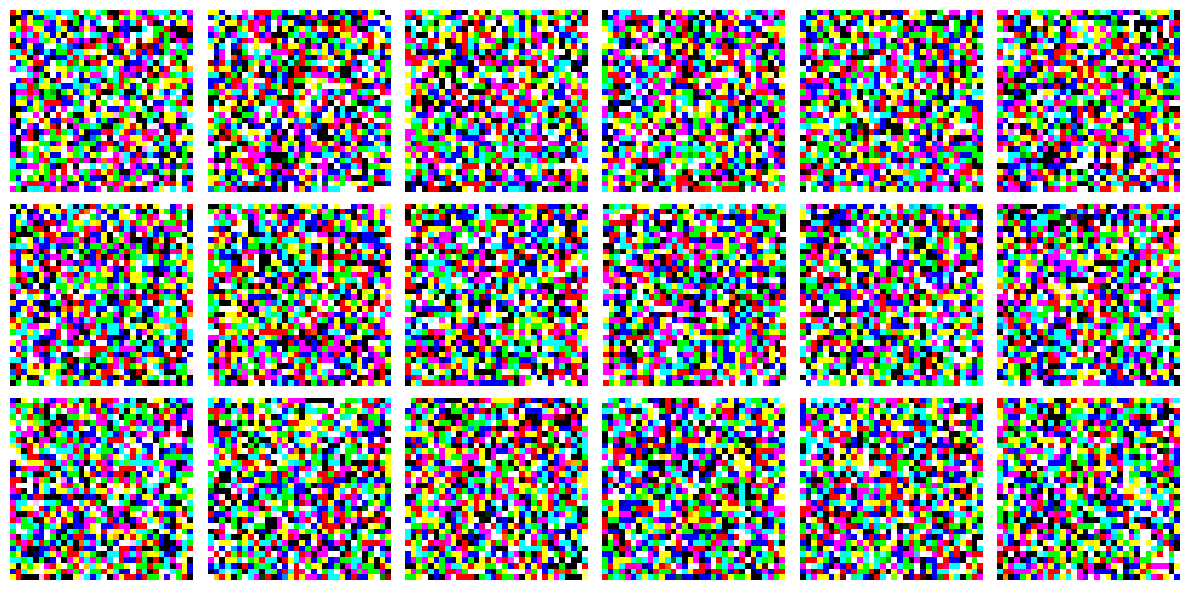

937/937 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - i_loss: 0.4802 - n_loss: 0.1810 - kid: 0.0000e+00 - val_i_loss: 2.3141 - val_kid: 0.8879 - val_n_loss: 0.7478
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1584 - n_loss: 0.0737

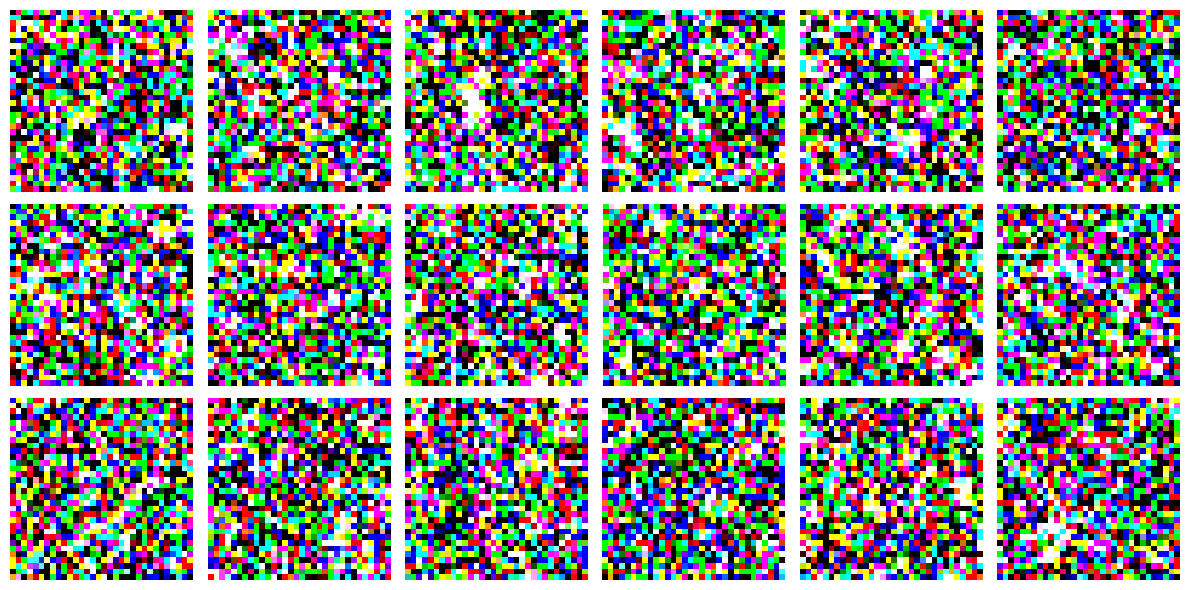

937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - i_loss: 0.1584 - n_loss: 0.0737 - kid: 0.0000e+00 - val_i_loss: 1.4680 - val_kid: 0.8443 - val_n_loss: 0.5140
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1370 - n_loss: 0.0648

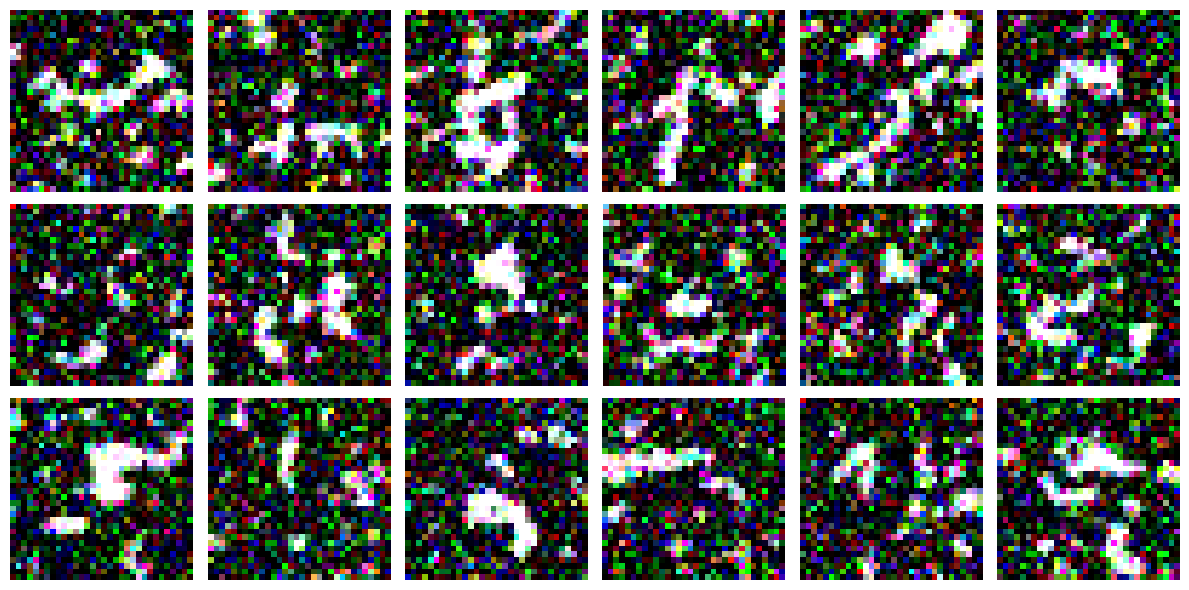

937/937 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - i_loss: 0.1370 - n_loss: 0.0648 - kid: 0.0000e+00 - val_i_loss: 0.7428 - val_kid: 1.1407 - val_n_loss: 0.2744
Epoch 4/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1274 - n_loss: 0.0596

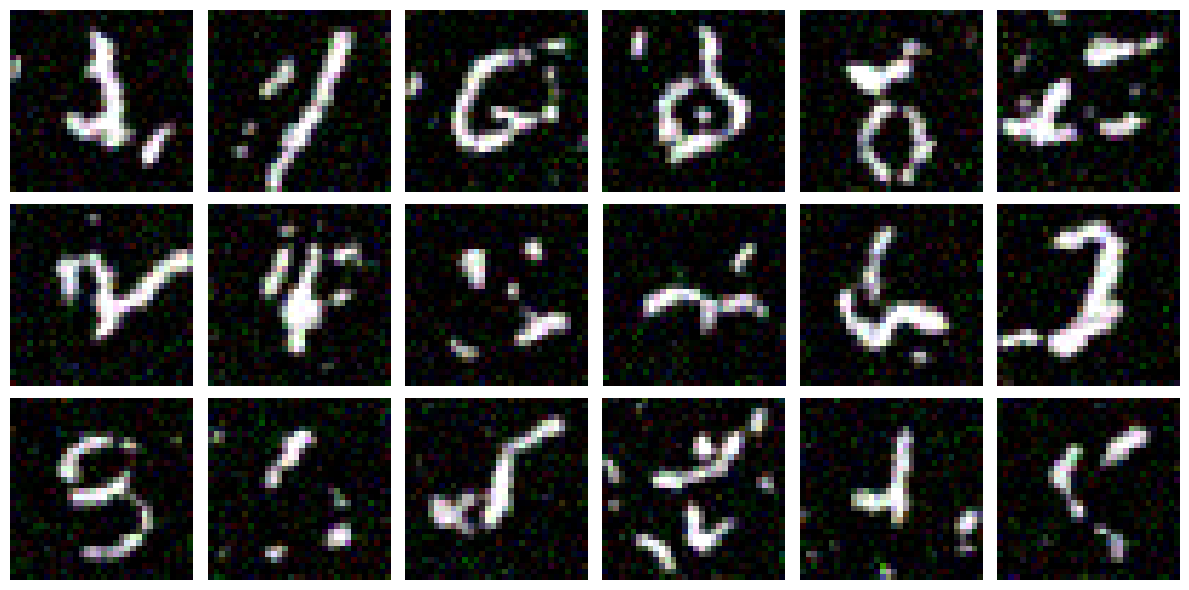

937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - i_loss: 0.1274 - n_loss: 0.0596 - kid: 0.0000e+00 - val_i_loss: 0.3596 - val_kid: 0.5154 - val_n_loss: 0.1390
Epoch 5/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1202 - n_loss: 0.0569

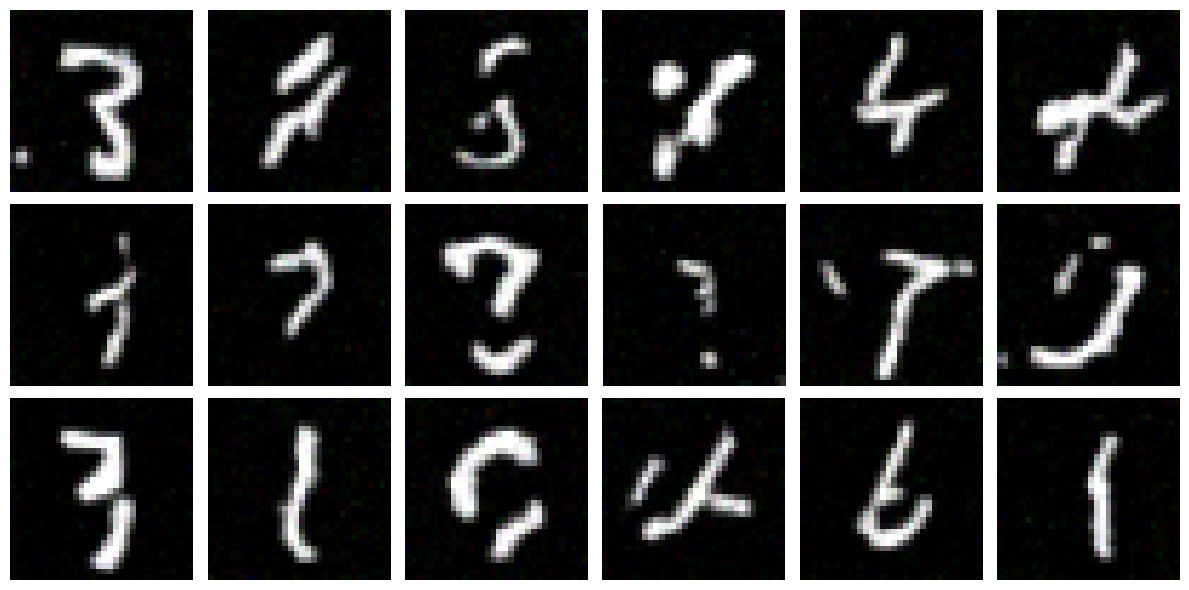

937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - i_loss: 0.1202 - n_loss: 0.0569 - kid: 0.0000e+00 - val_i_loss: 0.1954 - val_kid: 0.2870 - val_n_loss: 0.0792
Epoch 6/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1156 - n_loss: 0.0549

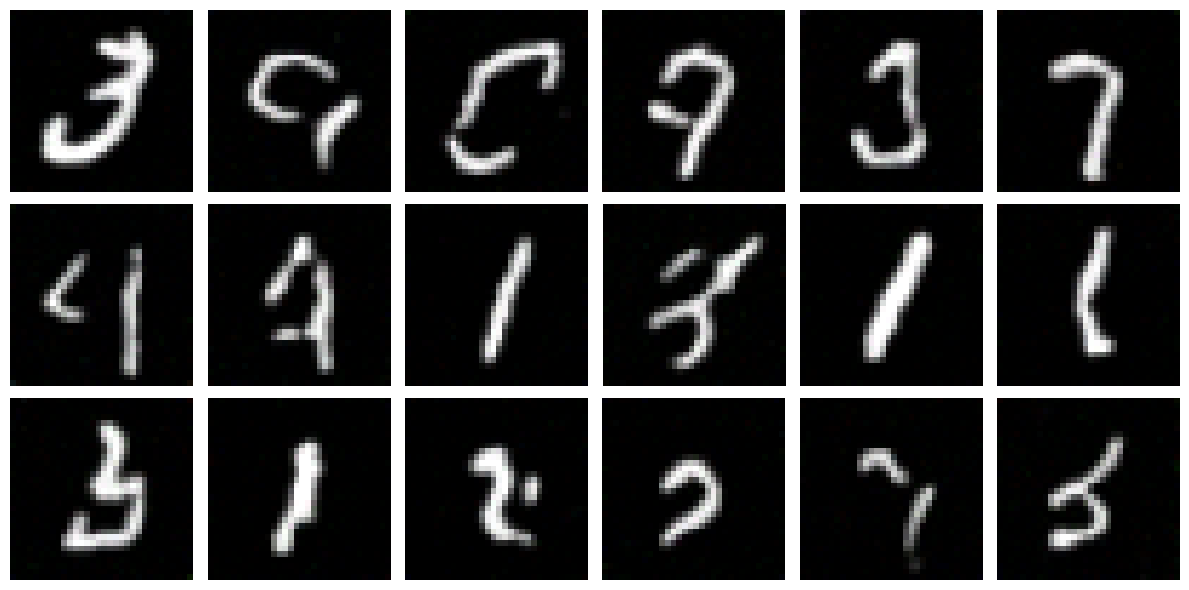

937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - i_loss: 0.1156 - n_loss: 0.0549 - kid: 0.0000e+00 - val_i_loss: 0.1293 - val_kid: 0.1624 - val_n_loss: 0.0562
Epoch 7/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1133 - n_loss: 0.0536

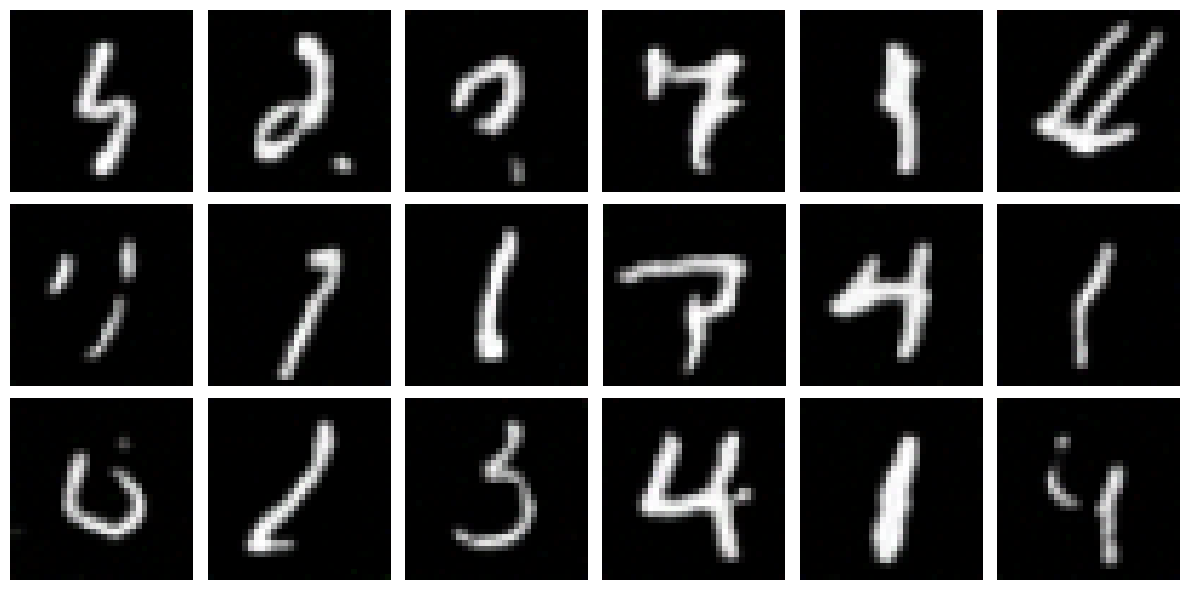

937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - i_loss: 0.1133 - n_loss: 0.0536 - kid: 0.0000e+00 - val_i_loss: 0.1044 - val_kid: 0.0812 - val_n_loss: 0.0480
Epoch 8/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1102 - n_loss: 0.0521

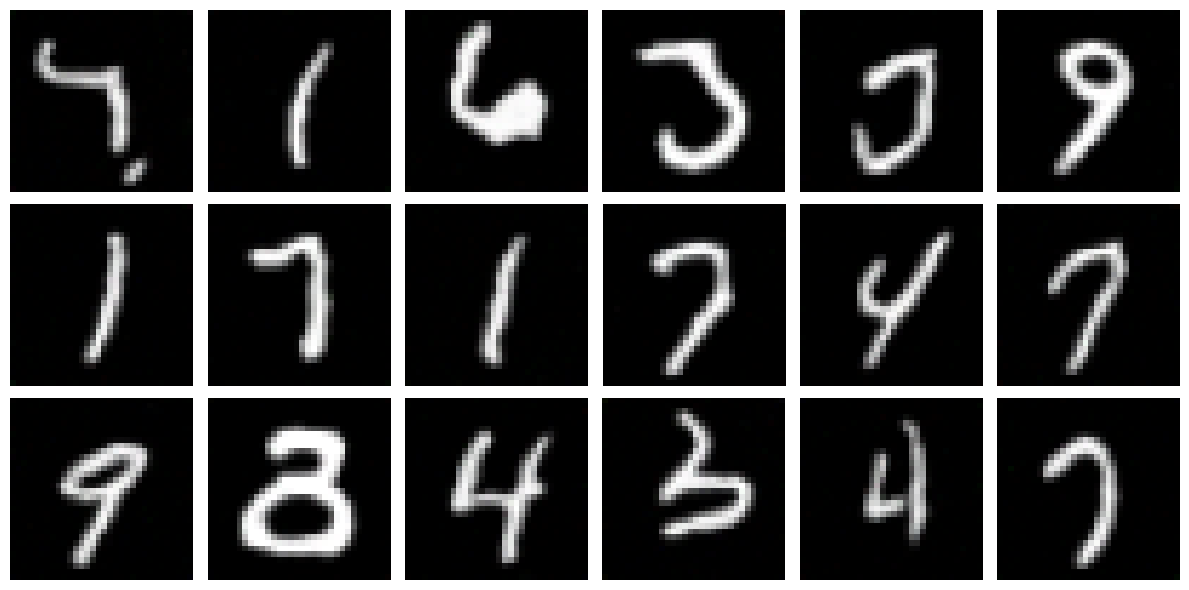

937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - i_loss: 0.1102 - n_loss: 0.0521 - kid: 0.0000e+00 - val_i_loss: 0.0973 - val_kid: 0.0597 - val_n_loss: 0.0446
Epoch 9/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1081 - n_loss: 0.0510

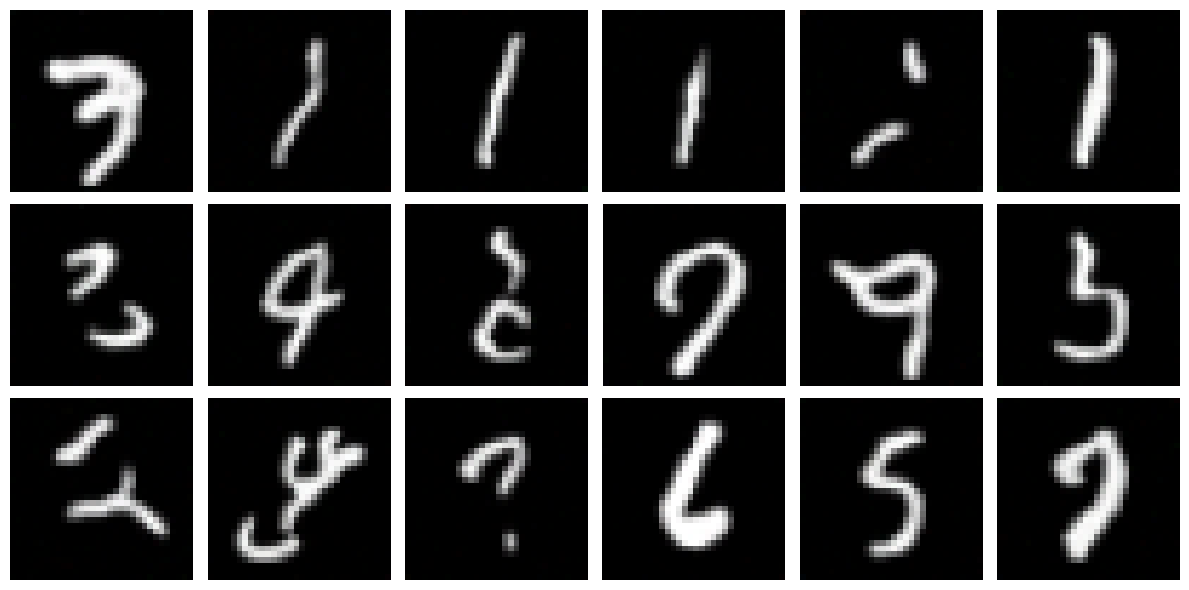

937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - i_loss: 0.1081 - n_loss: 0.0510 - kid: 0.0000e+00 - val_i_loss: 0.0903 - val_kid: 0.0543 - val_n_loss: 0.0435
Epoch 10/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1080 - n_loss: 0.0505

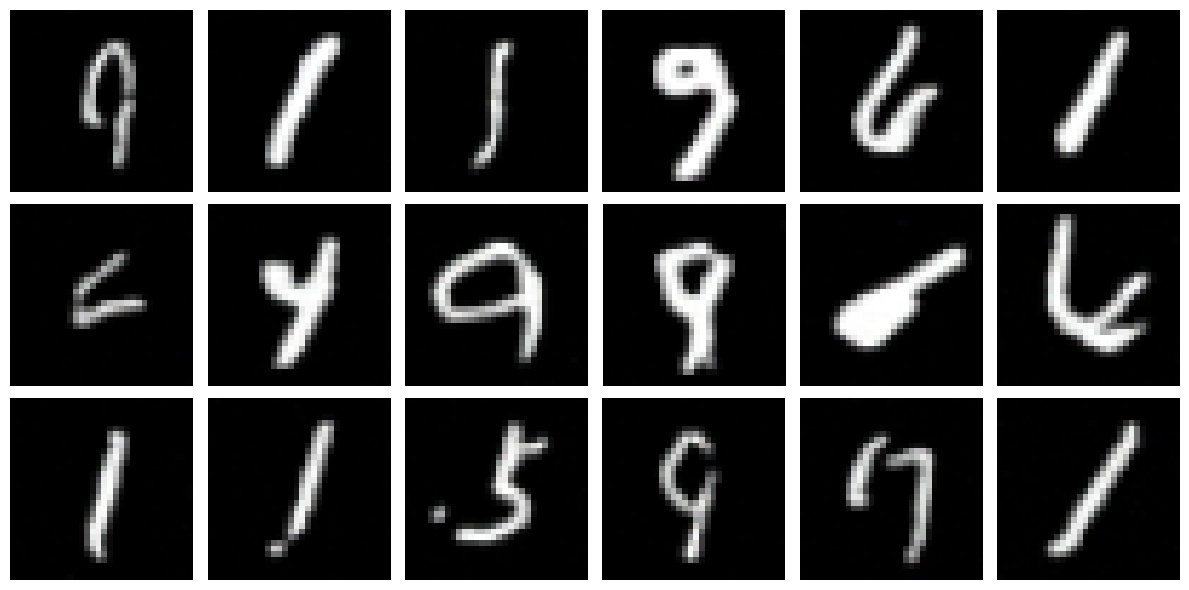

937/937 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - i_loss: 0.1080 - n_loss: 0.0505 - kid: 0.0000e+00 - val_i_loss: 0.0905 - val_kid: 0.0523 - val_n_loss: 0.0425
Epoch 11/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1058 - n_loss: 0.0502

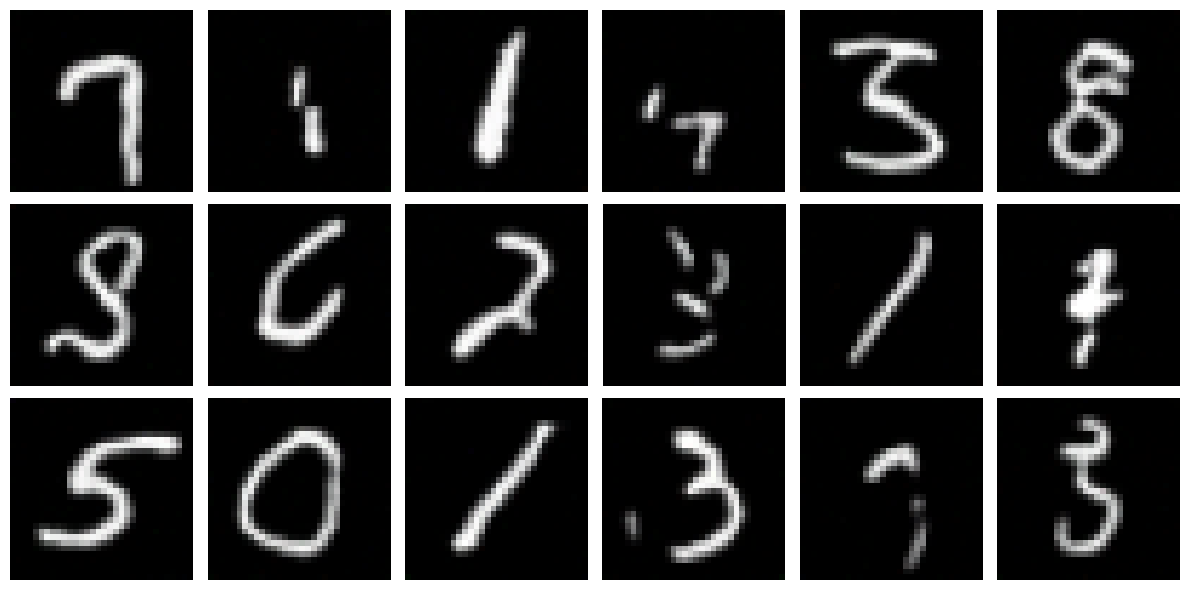

937/937 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - i_loss: 0.1058 - n_loss: 0.0502 - kid: 0.0000e+00 - val_i_loss: 0.0878 - val_kid: 0.0573 - val_n_loss: 0.0422
Epoch 12/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - i_loss: 0.1036 - n_loss: 0.0486

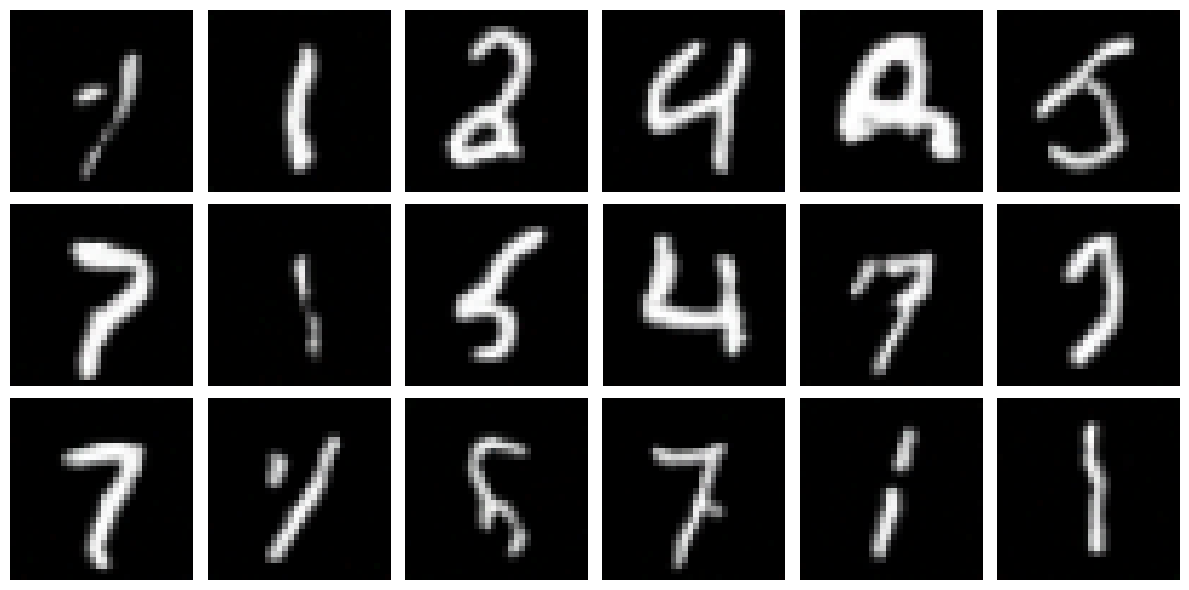

937/937 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - i_loss: 0.1036 - n_loss: 0.0486 - kid: 0.0000e+00 - val_i_loss: 0.0884 - val_kid: 0.0475 - val_n_loss: 0.0415
Epoch 13/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1027 - n_loss: 0.0484

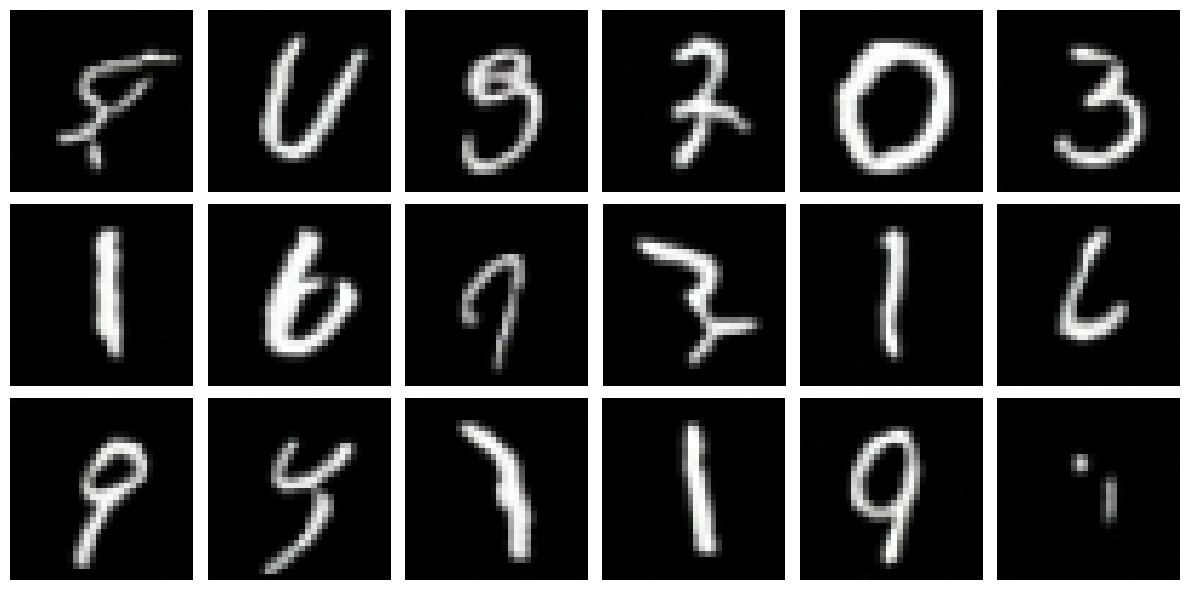

937/937 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - i_loss: 0.1027 - n_loss: 0.0484 - kid: 0.0000e+00 - val_i_loss: 0.0868 - val_kid: 0.0438 - val_n_loss: 0.0412
Epoch 14/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1019 - n_loss: 0.0476

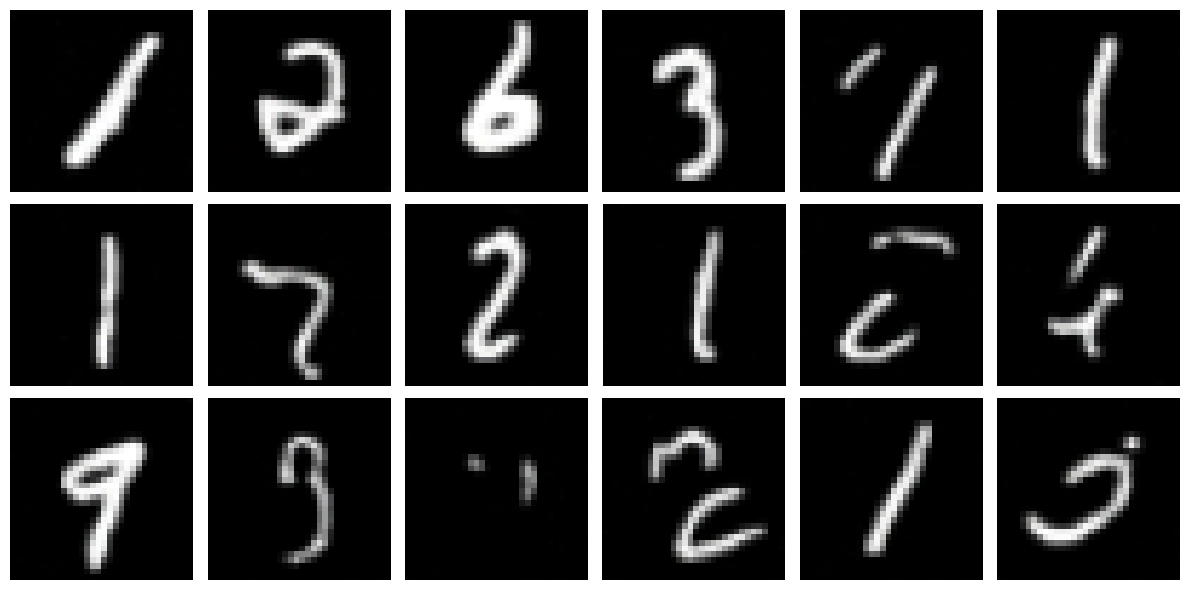

937/937 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - i_loss: 0.1019 - n_loss: 0.0476 - kid: 0.0000e+00 - val_i_loss: 0.0865 - val_kid: 0.0456 - val_n_loss: 0.0406
Epoch 15/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - i_loss: 0.1004 - n_loss: 0.0473

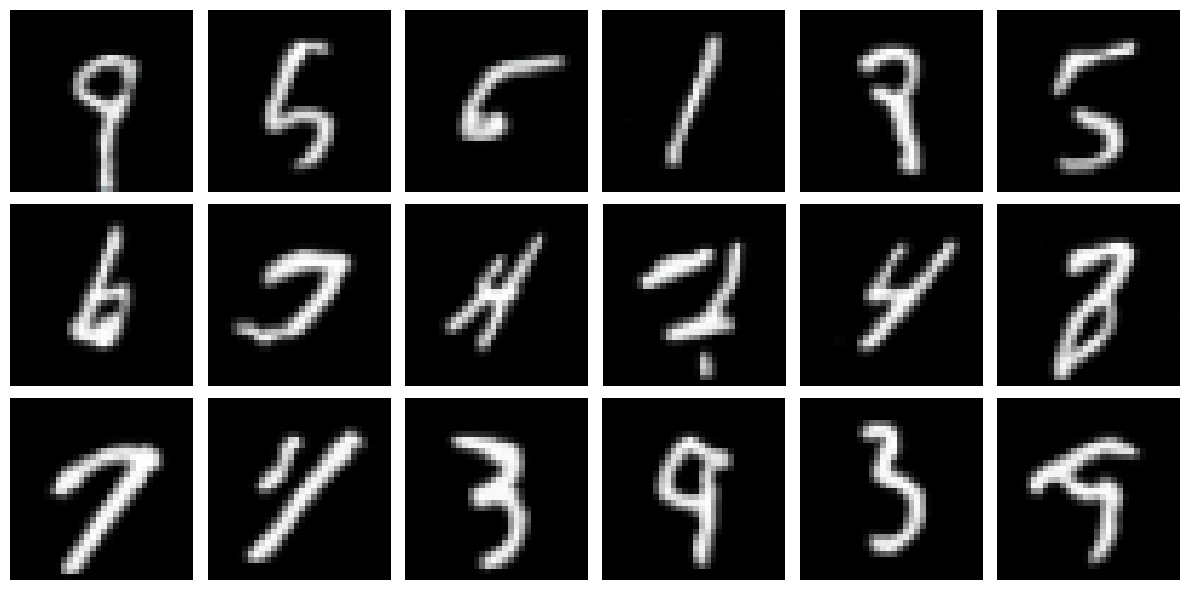

937/937 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - i_loss: 0.1004 - n_loss: 0.0473 - kid: 0.0000e+00 - val_i_loss: 0.0855 - val_kid: 0.0436 - val_n_loss: 0.0403
Epoch 16/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.1003 - n_loss: 0.0471

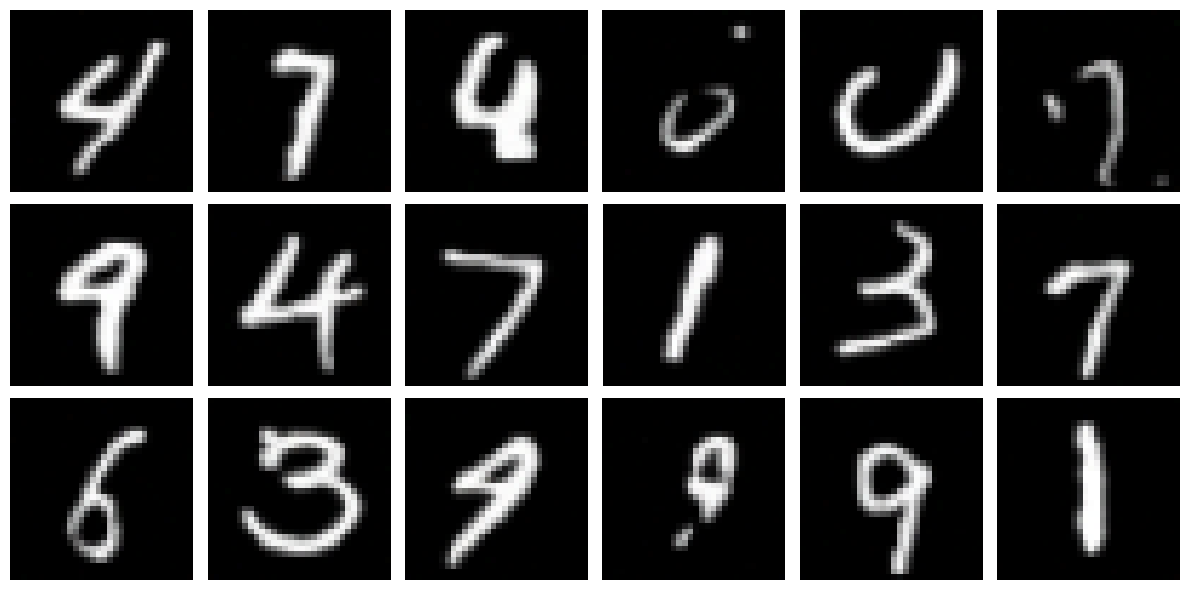

937/937 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - i_loss: 0.1003 - n_loss: 0.0471 - kid: 0.0000e+00 - val_i_loss: 0.0852 - val_kid: 0.0459 - val_n_loss: 0.0402
Epoch 17/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.0994 - n_loss: 0.0465

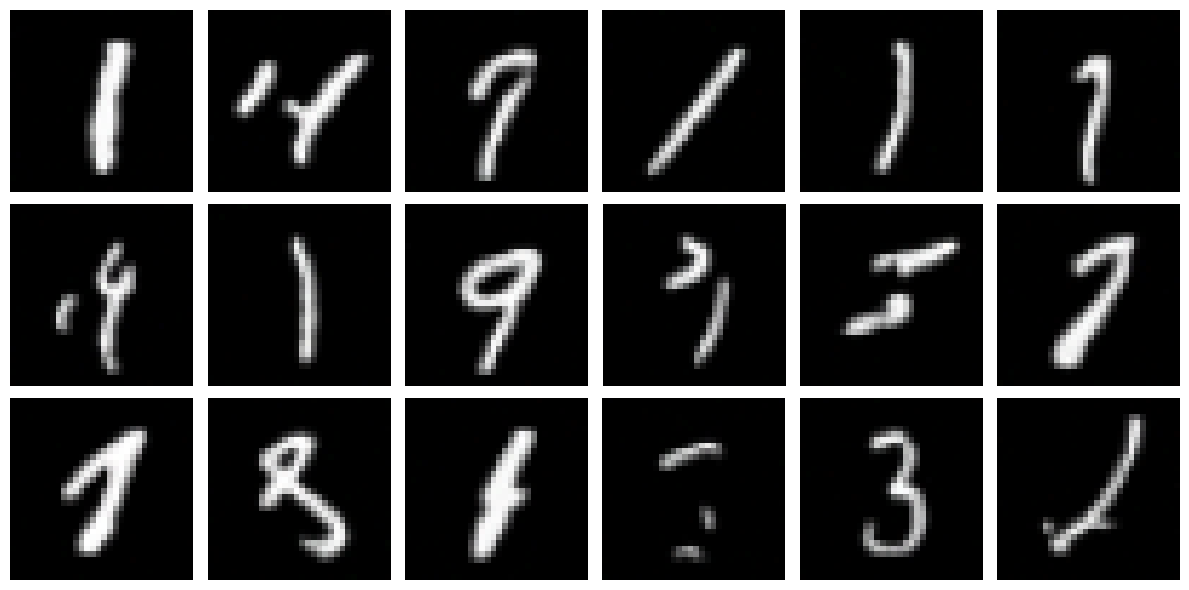

937/937 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - i_loss: 0.0994 - n_loss: 0.0465 - kid: 0.0000e+00 - val_i_loss: 0.0842 - val_kid: 0.0448 - val_n_loss: 0.0399
Epoch 18/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.0995 - n_loss: 0.0467

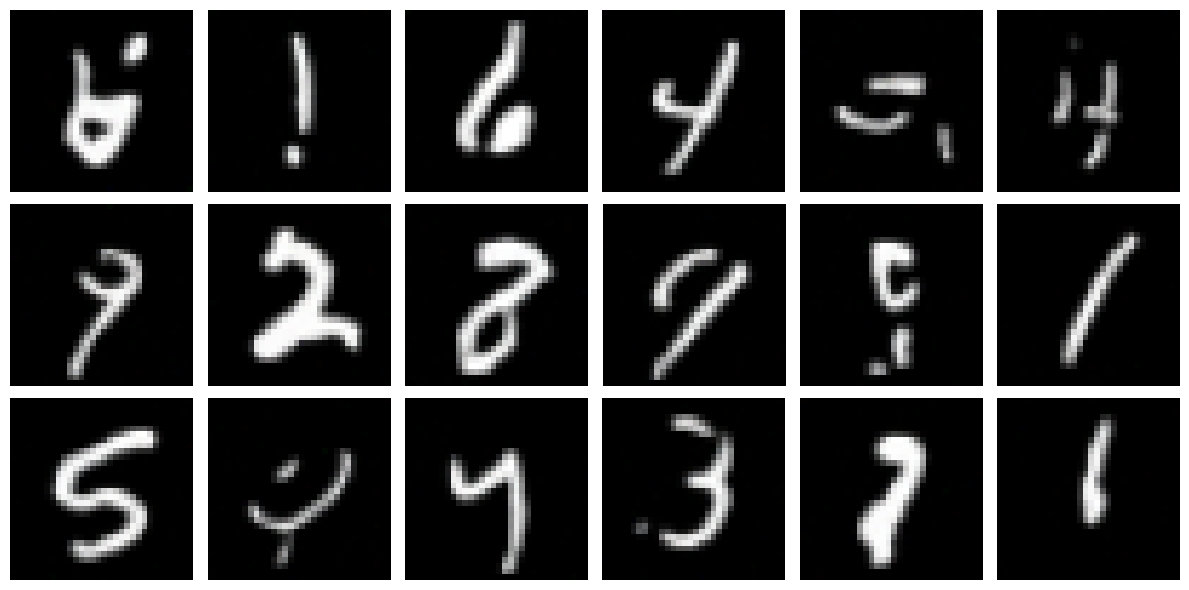

937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - i_loss: 0.0995 - n_loss: 0.0467 - kid: 0.0000e+00 - val_i_loss: 0.0846 - val_kid: 0.0396 - val_n_loss: 0.0396
Epoch 19/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.0992 - n_loss: 0.0460

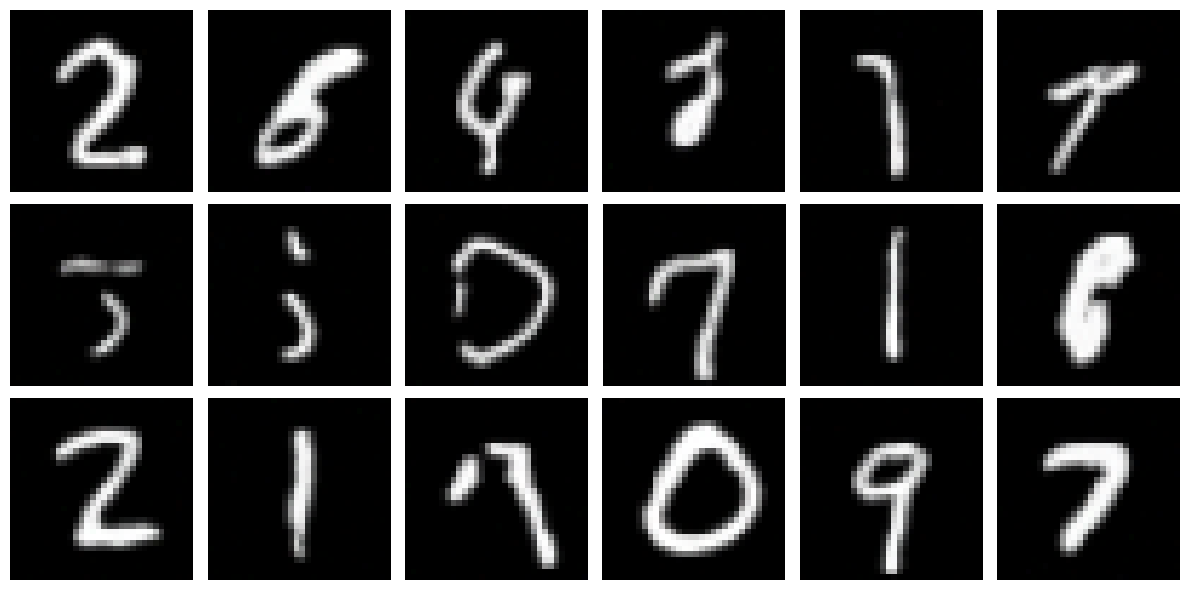

937/937 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - i_loss: 0.0992 - n_loss: 0.0460 - kid: 0.0000e+00 - val_i_loss: 0.0832 - val_kid: 0.0423 - val_n_loss: 0.0395
Epoch 20/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - i_loss: 0.0980 - n_loss: 0.0456

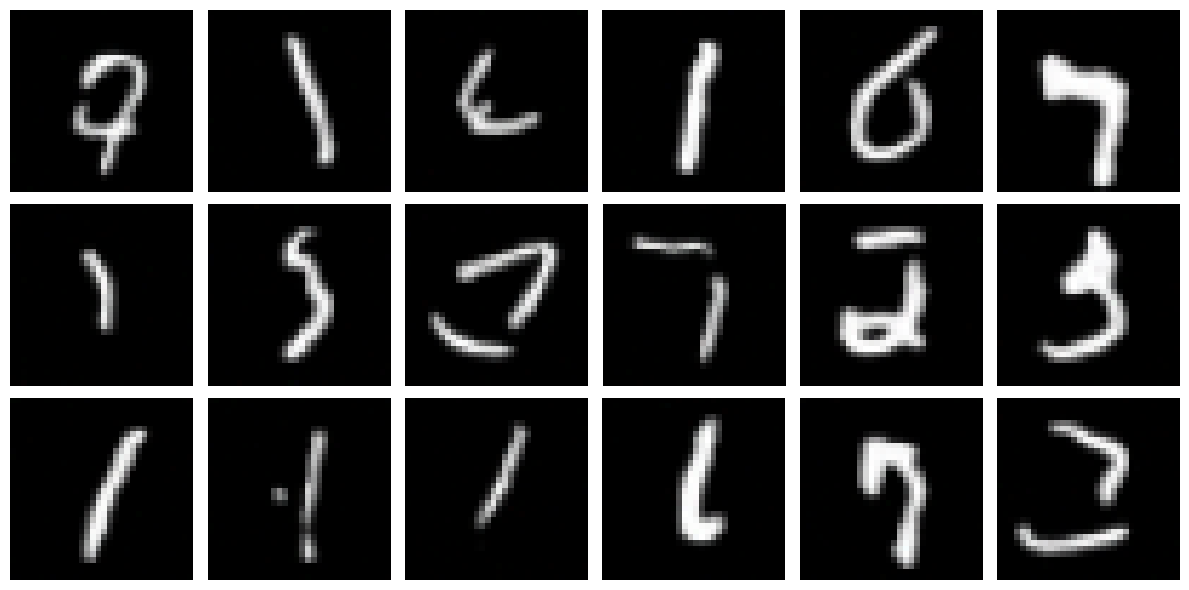

937/937 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - i_loss: 0.0980 - n_loss: 0.0456 - kid: 0.0000e+00 - val_i_loss: 0.0833 - val_kid: 0.0437 - val_n_loss: 0.0392


In [12]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/diffusion_model.weights.h5"
model.load_weights(checkpoint_path)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset.map(lambda x, y: x))

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

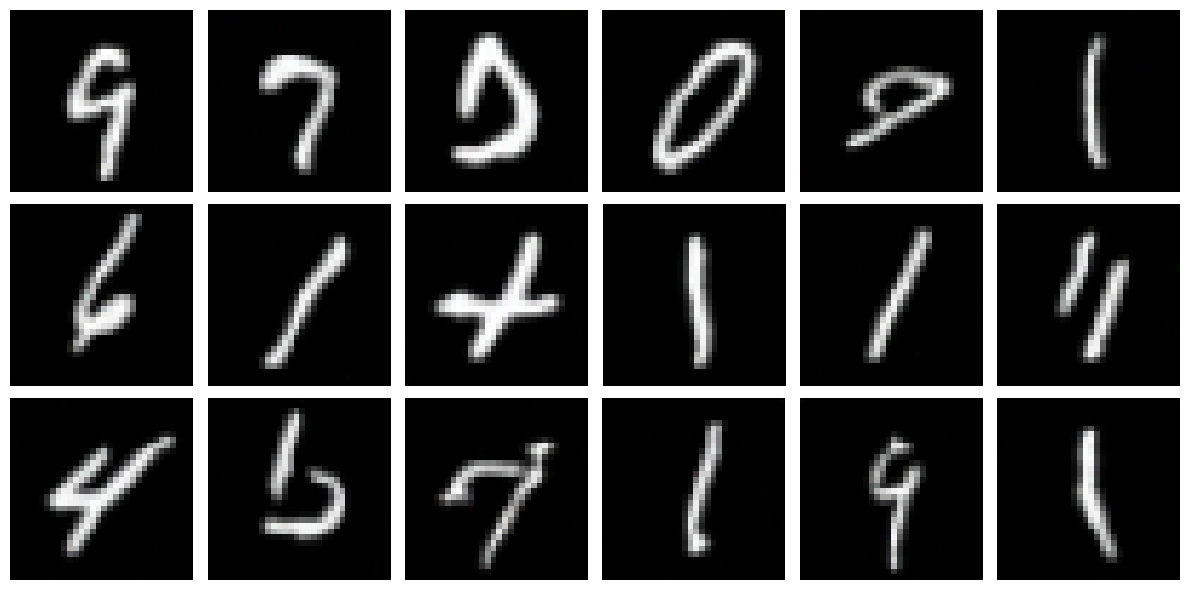

In [13]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


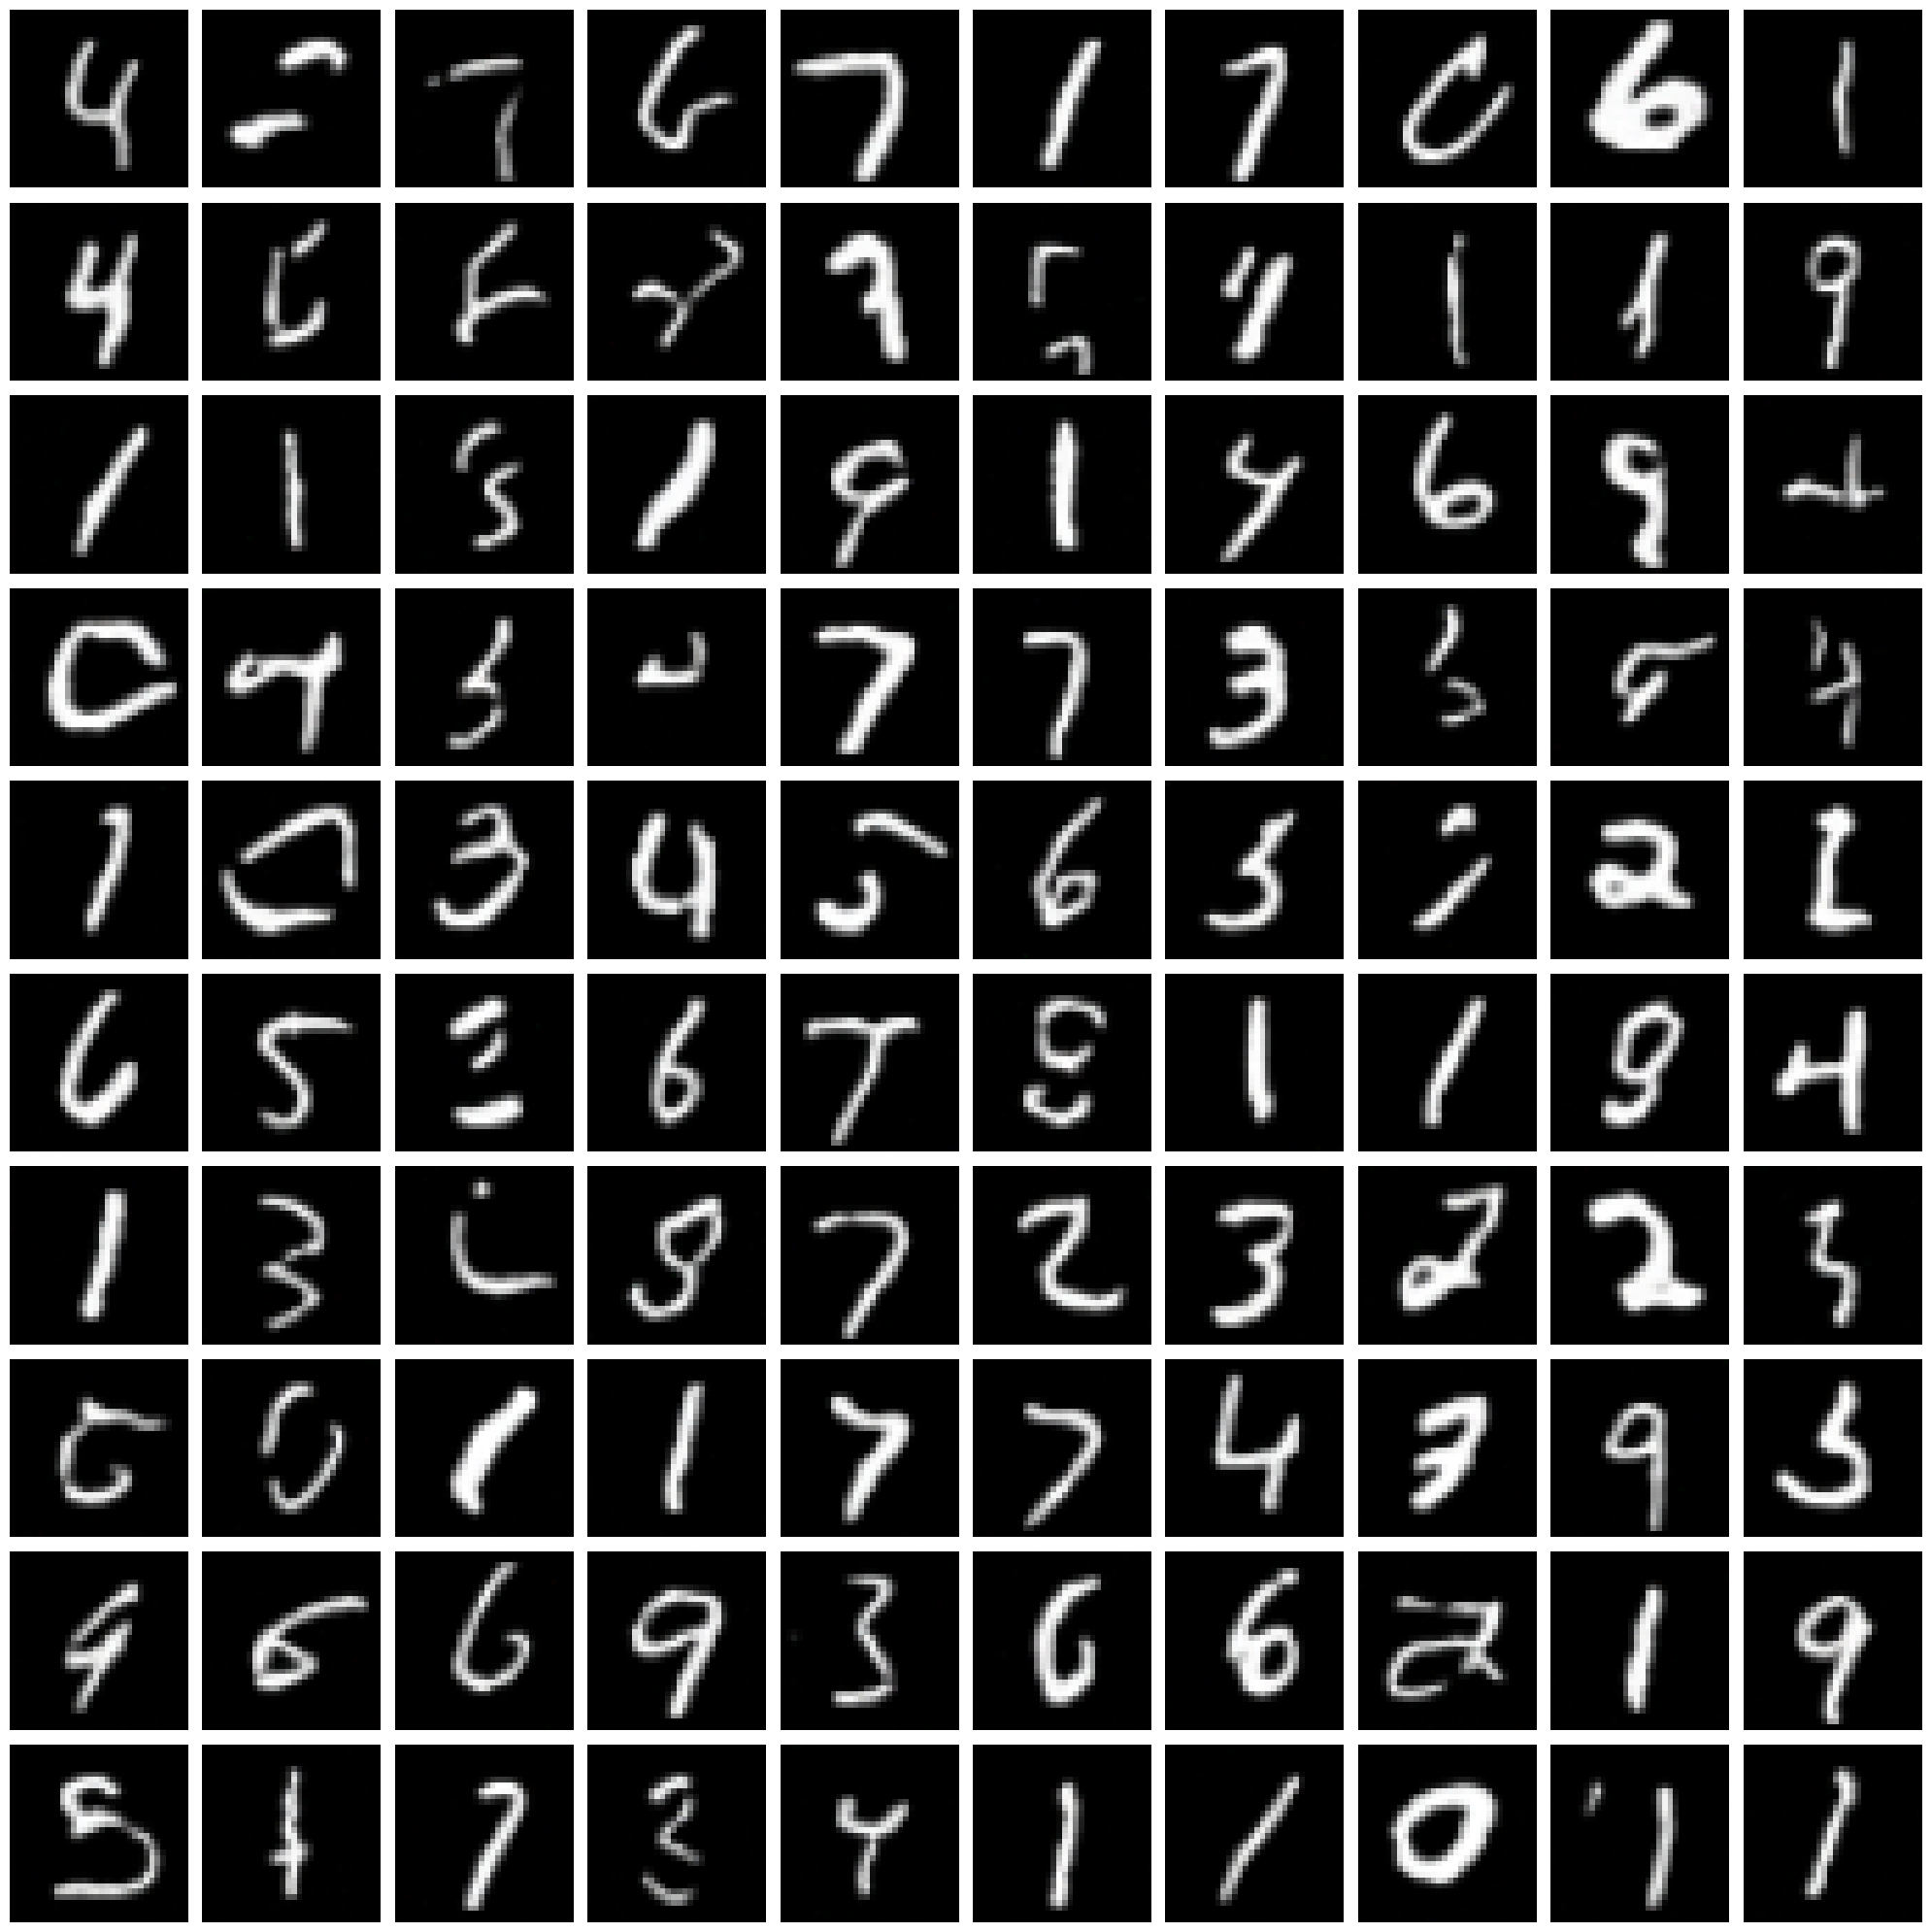

In [15]:
labels = [0]*10 + [1]*10 + [2]*10 + [3]*10 + [4]*10 + [5]*10 + [6]*10 + [7]*10 + [8]*10 + [9]*10
print(labels)
model.plot_images(labels=labels, num_cols=10, num_rows=10)

In [16]:
labels = tf.convert_to_tensor(labels, dtype=tf.int32)
labels = tf.reshape(labels, [10 * 10, 1, 1])
print(labels)

tf.Tensor(
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[1]]

 [[1]]

 [[1]]

 [[1]]

 [[1]]

 [[1]]

 [[1]]

 [[1]]

 [[1]]

 [[1]]

 [[2]]

 [[2]]

 [[2]]

 [[2]]

 [[2]]

 [[2]]

 [[2]]

 [[2]]

 [[2]]

 [[2]]

 [[3]]

 [[3]]

 [[3]]

 [[3]]

 [[3]]

 [[3]]

 [[3]]

 [[3]]

 [[3]]

 [[3]]

 [[4]]

 [[4]]

 [[4]]

 [[4]]

 [[4]]

 [[4]]

 [[4]]

 [[4]]

 [[4]]

 [[4]]

 [[5]]

 [[5]]

 [[5]]

 [[5]]

 [[5]]

 [[5]]

 [[5]]

 [[5]]

 [[5]]

 [[5]]

 [[6]]

 [[6]]

 [[6]]

 [[6]]

 [[6]]

 [[6]]

 [[6]]

 [[6]]

 [[6]]

 [[6]]

 [[7]]

 [[7]]

 [[7]]

 [[7]]

 [[7]]

 [[7]]

 [[7]]

 [[7]]

 [[7]]

 [[7]]

 [[8]]

 [[8]]

 [[8]]

 [[8]]

 [[8]]

 [[8]]

 [[8]]

 [[8]]

 [[8]]

 [[8]]

 [[9]]

 [[9]]

 [[9]]

 [[9]]

 [[9]]

 [[9]]

 [[9]]

 [[9]]

 [[9]]

 [[9]]], shape=(100, 1, 1), dtype=int32)
